# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [73]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [76]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
vocabulary = vocab(
    Counter(token for text in tqdm(train_df["text"]) for token in tokenizer(text)),
    min_freq=10,
    specials=["<unk>", "<pad>"])
vocabulary.set_default_index(vocabulary["<unk>"])

  0%|          | 0/20000 [00:00<?, ?it/s]

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [77]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

In [78]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [79]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  39, 4850,   11,  265,  646,    8,   27,   27,   27,    0])

In [80]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [81]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [torch.cat([x, torch.ones(max_len - len(x), dtype=torch.long) * pad_id]) for x in batch_X]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [82]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember, an RNN has 3 elements.
* An embedding layer to turn one-hot vectors into dense vectors.
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the hidden layer of our next step.
  * `embedding_size + hidden_size -> hidden_size`
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the output.
  * `embedding_size + hidden_size -> 1`
* The provided `init_hidden` function sho

In [83]:
# Create a RNN classes with the following architecture:
# - The embedding layer turns a one-hot vectors into dense vectors.
# - The first matrix (W) connects the embedding to the hidden layer.
#       embedding_size -> hidden_size
# - The second matrix (U) connect the previous hidden layer to the current one.
#       hidden_size -> hidden_size
# - These to vectors are added and go through an activation function (e.g. h_t = tanh(Wx_i+Uh_{t-1})).
# - The last matrix (V) connects the hidden layer to the hidden layer to the output.
#       hidden_size -> 1
# - Don't forget to add an init_hidden function which initialize the first hidden layer to 0.

class RNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_size: int, hidden_size: int):
        """
        Args:
            vocab_size: the size of the vocabulary.
            embedding_size: the size of the embedding layer.
            hidden_size: the size of the hidden layer.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.hidden_size = hidden_size
        self.hidden = nn.Linear(embedding_size + hidden_size, hidden_size, activation="tanh")
        self.out = nn.Linear(embedding_size + hidden_size, 1)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the RNN.
        Args:
            x: the input tensor of shape (batch_size, sequence_length).
            hidden: the hidden state of the previous step of shape (batch_size, hidden_size).
        Returns:
            The output tensor of shape (batch_size, 1).
        """
        x = self.embedding(x)
        x = torch.cat([x, hidden], dim=1)
        hidden = self.hidden(x)
        out = self.out(x)
        return out, hidden

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialize the hidden state of the RNN.
        Args:
            batch_size: the size of the batch.
        Returns:
            A tensor of zeros of shape (batch_size, hidden_size).
        """
        return torch.zeros(batch_size, self.hidden_size)


## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [84]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [85]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/3 - train loss: 0.022 - valid loss: 0.022


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2/3 - train loss: 0.022 - valid loss: 0.022


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3/3 - train loss: 0.022 - valid loss: 0.022


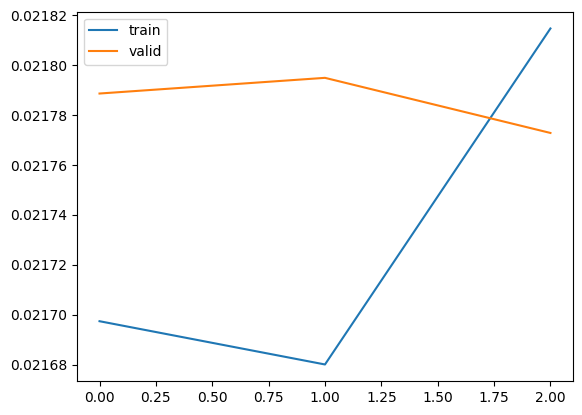

In [86]:
# train the model
from matplotlib import pyplot as plt


n_epochs = 3
best_valid_loss = np.inf
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    # train
    model.train()
    train_loss = 0
    for X, y in tqdm(train_gen()):
        optimizer.zero_grad()
        hidden = model.init_hidden(X.shape[0]).to(device)
        for i in range(X.shape[1]):
            out, hidden = model(X[:, i].to(device), hidden)
        loss = criterion(out.squeeze(), y.to(device).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train)
    train_losses.append(train_loss)
    # valid
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in tqdm(valid_gen()):
            hidden = model.init_hidden(X.shape[0]).to(device)
            for i in range(X.shape[1]):
                out, hidden = model(X[:, i].to(device), hidden)
            loss = criterion(out.squeeze(), y.to(device).float())
            valid_loss += loss.item()
    valid_loss /= len(X_valid)
    valid_losses.append(valid_loss)
    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")
    print(
        f"Epoch {epoch + 1}/{n_epochs} - train loss: {train_loss:.3f} - valid loss: {valid_loss:.3f}"
    )

plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.legend()
plt.show()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [87]:
def compute_accuracy(model: nn.Module, data_gen: Callable[[], Generator[Tuple[torch.Tensor, torch.Tensor], None, None]]) -> float:
    """
    Compute the accuracy of the model on the given data.
    Args:
        model: the model to evaluate.
        data_gen: a data generator which yields batches of data.
    Returns:
        The accuracy of the model on the data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_gen():
            hidden = model.init_hidden(X.shape[0]).to(device)
            for i in range(X.shape[1]):
                out, hidden = model(X[:, i].to(device), hidden)
            pred = (out > 0).squeeze().long()
            correct += (pred == y.to(device)).sum().item()
            total += len(y)
    return correct / total

In [88]:
model.load_state_dict(torch.load("best_model.pt"))
train_acc = compute_accuracy(model, train_gen)
valid_acc = compute_accuracy(model, valid_gen)
test_acc = compute_accuracy(model, test_gen)
print(f"Train accuracy: {train_acc:.3f}, valid accuracy: {valid_acc:.3f}, test accuracy: {test_acc:.3f}")

Train accuracy: 0.503, valid accuracy: 0.503, test accuracy: 0.502
